In [92]:
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [93]:
TRAIN_BUF=60000
BATCH_SIZE=512
TEST_BUF=10000
DIMS = (28,28,1)
N_TRAIN_BATCHES =int(TRAIN_BUF/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_BUF/BATCH_SIZE)

In [94]:
# load dataset
train = pd.read_csv("mnist_train.csv")
train = train.astype(float)
X = train.iloc[:,1:]/255
Y = train.iloc[:,0]
# Split train and validation sets
train_images, test_images, train_labels, test_labels = train_test_split(X, Y, test_size=0.2)
test_labels = test_labels.squeeze()

train_images = train_images.to_numpy()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype(
    "float32"
)

test_images = test_images.to_numpy()
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype("float32")

# batch datasets
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(TRAIN_BUF)
    .batch(BATCH_SIZE)
)
test_dataset = (
    tf.data.Dataset.from_tensor_slices(test_images)
    .shuffle(TEST_BUF)
    .batch(BATCH_SIZE)
)


In [95]:
class GAN(tf.keras.Model):
    """ a basic GAN class 
    Extends:
        tf.keras.Model
    """

    def __init__(self, **kwargs):
        super(GAN, self).__init__()
        self.__dict__.update(kwargs)

        self.gen = tf.keras.Sequential(self.gen)
        self.disc = tf.keras.Sequential(self.disc)

    def generate(self, z):
        return self.gen(z)

    def discriminate(self, x):
        return self.disc(x)

    def compute_loss(self, x):
        """ passes through the network and computes loss
        """
        # generating noise from a uniform distribution
        z_samp = tf.random.normal([x.shape[0], 1, 1, self.n_Z])

        # run noise through generator
        x_gen = self.generate(z_samp)
        # discriminate x and x_gen
        logits_x = self.discriminate(x)
        logits_x_gen = self.discriminate(x_gen)
        ### losses
        # losses of real with label "1"
        disc_real_loss = gan_loss(logits=logits_x, is_real=True)
        # losses of fake with label "0"
        disc_fake_loss = gan_loss(logits=logits_x_gen, is_real=False)
        disc_loss = disc_fake_loss + disc_real_loss

        # losses of fake with label "1"
        gen_loss = gan_loss(logits=logits_x_gen, is_real=True)

        return disc_loss, gen_loss

    def compute_gradients(self, x):
        """ passes through the network and computes loss
        """
        ### pass through network
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            disc_loss, gen_loss = self.compute_loss(x)

        # compute gradients
        gen_gradients = gen_tape.gradient(gen_loss, self.gen.trainable_variables)
        disc_gradients = disc_tape.gradient(disc_loss, self.disc.trainable_variables)

        return gen_gradients, disc_gradients

    def apply_gradients(self, gen_gradients, disc_gradients):

        self.gen_optimizer.apply_gradients(
            zip(gen_gradients, self.gen.trainable_variables)
        )
        self.disc_optimizer.apply_gradients(
            zip(disc_gradients, self.disc.trainable_variables)
        )
    @tf.function
    def train(self, train_x):
        gen_gradients, disc_gradients = self.compute_gradients(train_x)
        self.apply_gradients(gen_gradients, disc_gradients)
        
        
def gan_loss(logits, is_real=True):
    """Computes standard gan loss between logits and labels
    """
    if is_real:
        labels = tf.ones_like(logits)
    else:
        labels = tf.zeros_like(logits)

    return tf.compat.v1.losses.sigmoid_cross_entropy(
        multi_class_labels=labels, logits=logits
    )


In [96]:
N_Z = 64
generator = [
    tf.keras.layers.Dense(units=7 * 7 * 64, activation="relu"),
    tf.keras.layers.Reshape(target_shape=(7, 7, 64)),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation="sigmoid"
    ),
]

discriminator = [
    tf.keras.layers.InputLayer(input_shape=DIMS),
    tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1, activation=None),
]

In [97]:
# optimizers
gen_optimizer = tf.keras.optimizers.Adam(0.001, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.RMSprop(0.005)# train the model
# model
model = GAN(
    gen = generator,
    disc = discriminator,
    gen_optimizer = gen_optimizer,
    disc_optimizer = disc_optimizer,
    n_Z = N_Z
)

In [98]:
# exampled data for plotting results
def plot_reconstruction(model, nex=8, zm=2):
    samples = model.generate(tf.random.normal(shape=(BATCH_SIZE, N_Z)))
    fig, axs = plt.subplots(ncols=nex, nrows=1, figsize=(zm * nex, zm))
    for axi in range(nex):
        axs[axi].matshow(
                    samples.numpy()[axi].squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1
                )
        axs[axi].axis('off')
    plt.show()

In [99]:
# a pandas dataframe to save the loss information to
losses = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 0 | disc_loss: 0.11412536352872849 | gen_loss: 2.917687177658081


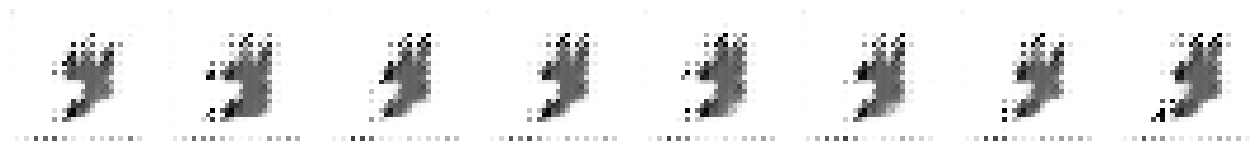

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 1 | disc_loss: 1.145493507385254 | gen_loss: 6.518315315246582


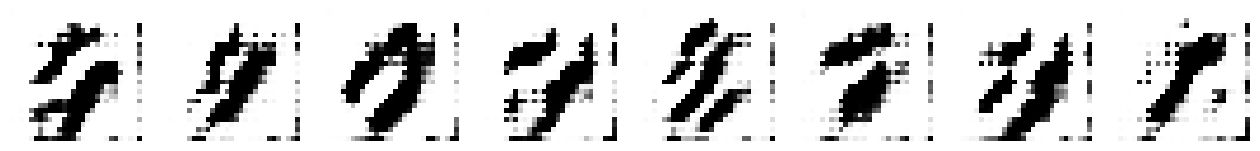

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 2 | disc_loss: 2.2448177337646484 | gen_loss: 0.17785920202732086


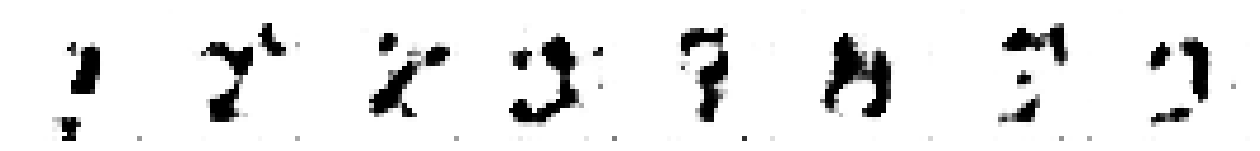

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 3 | disc_loss: 1.1917369365692139 | gen_loss: 0.5362949371337891


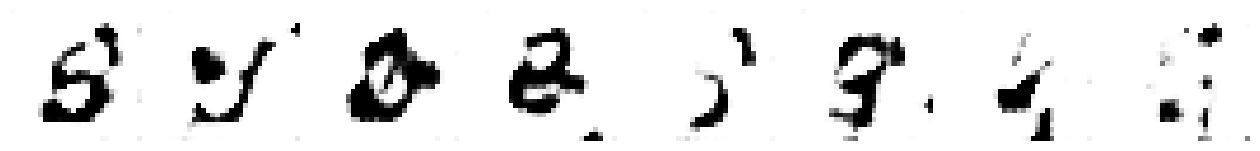

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 4 | disc_loss: 0.9006537199020386 | gen_loss: 0.9645065665245056


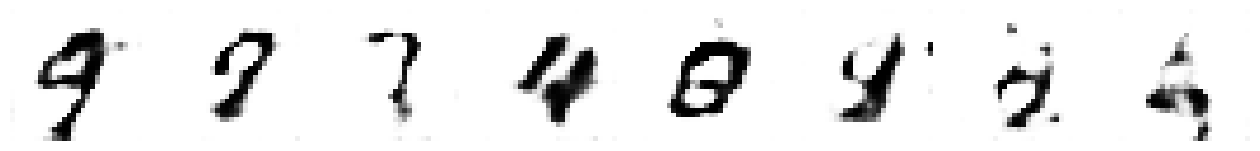

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 5 | disc_loss: 1.0011577606201172 | gen_loss: 0.7303910255432129


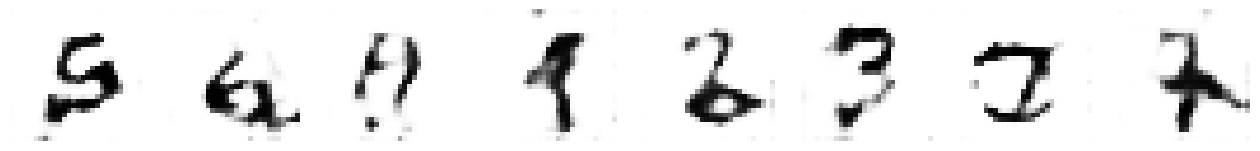

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 6 | disc_loss: 0.9189290404319763 | gen_loss: 0.9411582946777344


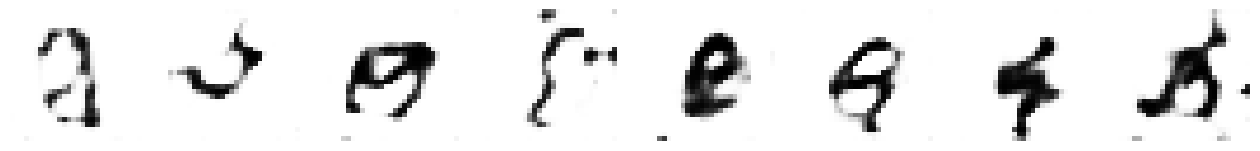

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 7 | disc_loss: 0.9094338417053223 | gen_loss: 0.9601183533668518


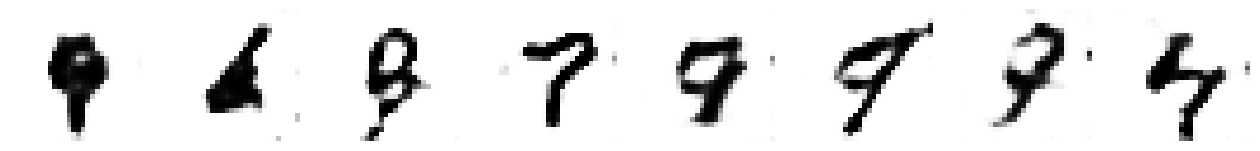

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 8 | disc_loss: 0.9644748568534851 | gen_loss: 0.8561756610870361


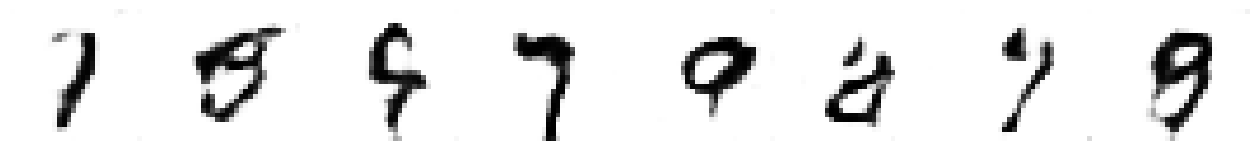

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 9 | disc_loss: 1.0302629470825195 | gen_loss: 0.7300350666046143


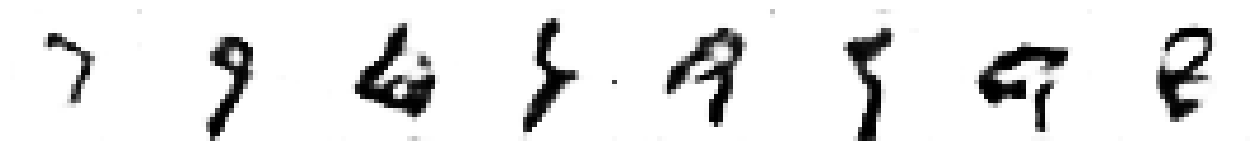

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 10 | disc_loss: 0.9084356427192688 | gen_loss: 0.9000558257102966


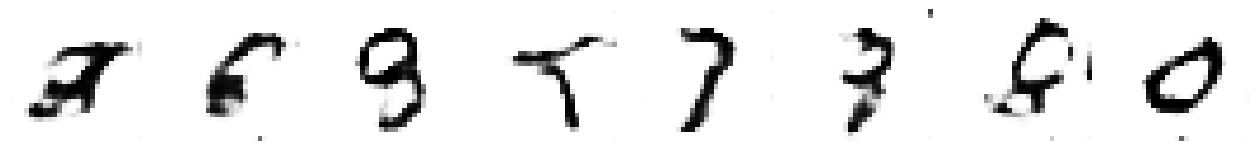

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 11 | disc_loss: 0.839238166809082 | gen_loss: 1.0088118314743042


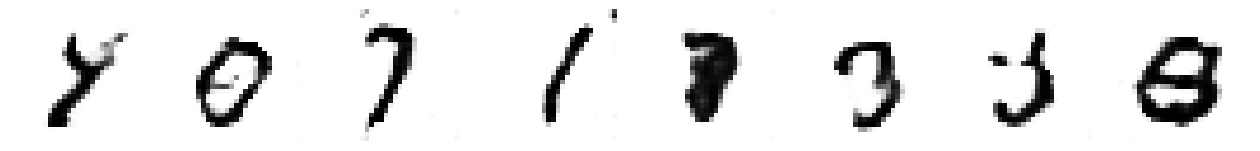

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 12 | disc_loss: 0.9151648283004761 | gen_loss: 0.9097896218299866


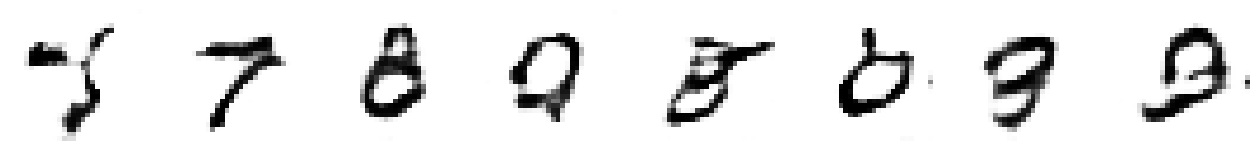

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 13 | disc_loss: 0.8215304017066956 | gen_loss: 1.0856198072433472


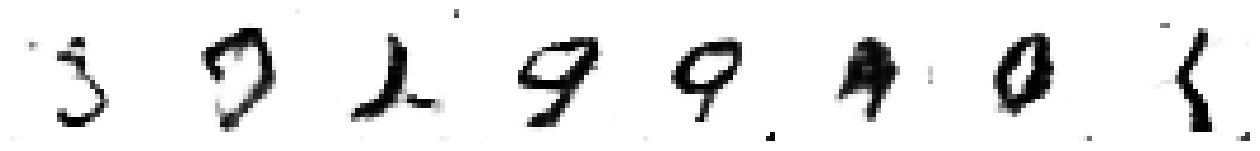

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 14 | disc_loss: 0.7451183795928955 | gen_loss: 1.3405728340148926


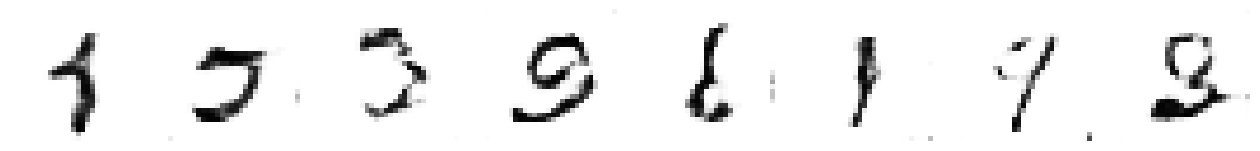

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 15 | disc_loss: 0.837332010269165 | gen_loss: 1.0311527252197266


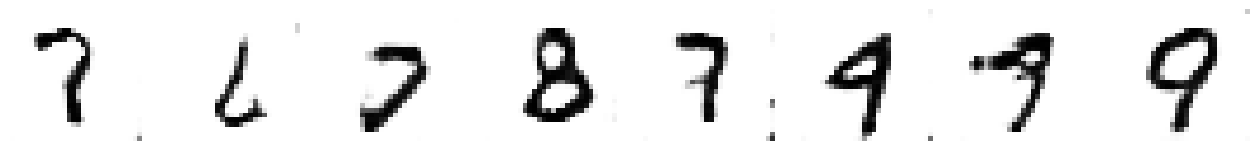

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 16 | disc_loss: 0.7910072207450867 | gen_loss: 1.2279176712036133


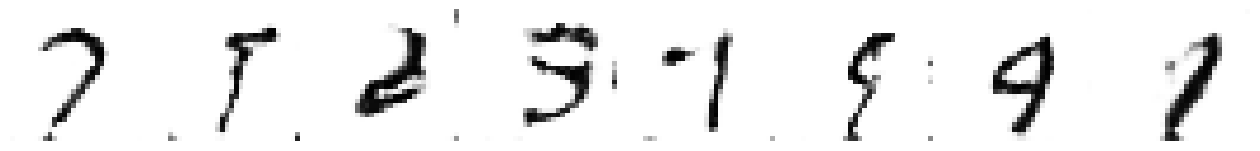

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 17 | disc_loss: 1.0061368942260742 | gen_loss: 0.7953431606292725


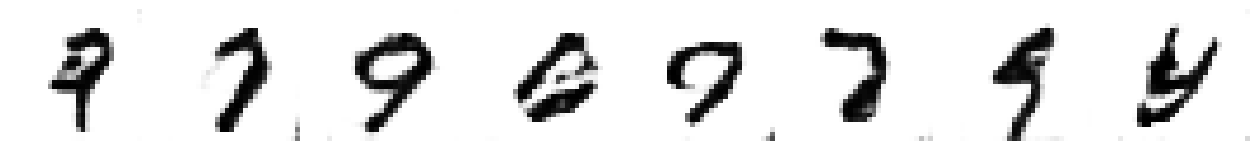

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 18 | disc_loss: 0.8774654269218445 | gen_loss: 0.9986791014671326


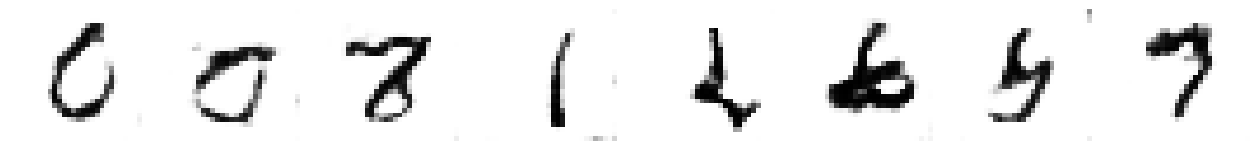

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 19 | disc_loss: 0.781594455242157 | gen_loss: 1.2562750577926636


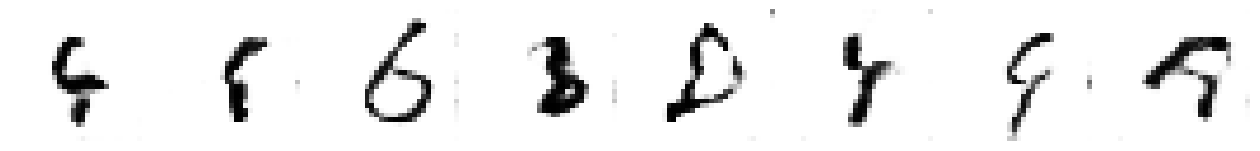

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 20 | disc_loss: 0.8536743521690369 | gen_loss: 1.1894891262054443


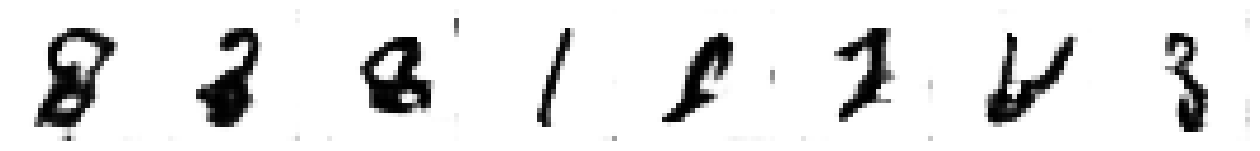

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 21 | disc_loss: 0.8704696297645569 | gen_loss: 1.0491985082626343


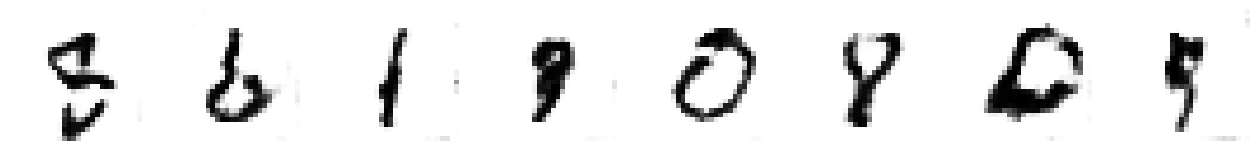

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 22 | disc_loss: 0.8285443782806396 | gen_loss: 1.1864029169082642


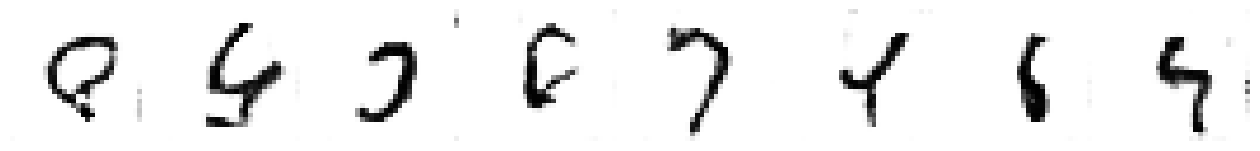

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 23 | disc_loss: 0.7628722190856934 | gen_loss: 1.602329134941101


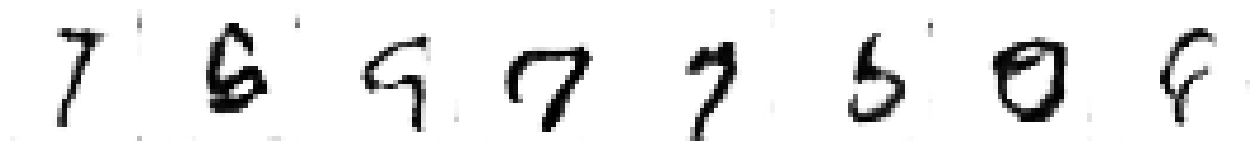

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 24 | disc_loss: 0.9434802532196045 | gen_loss: 0.9372671842575073


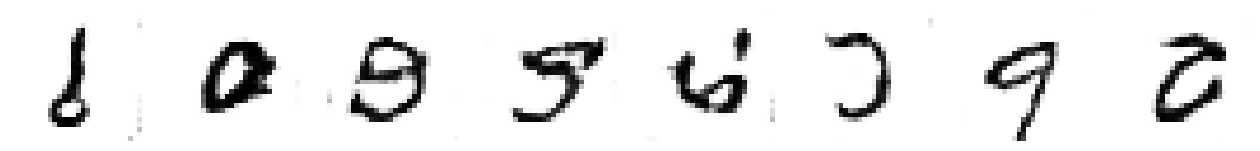

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 25 | disc_loss: 1.1049162149429321 | gen_loss: 0.7223210334777832


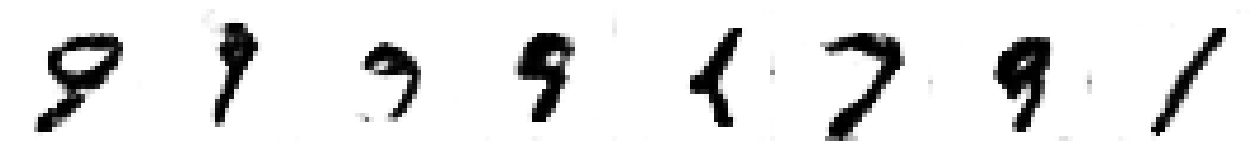

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 26 | disc_loss: 1.2251474857330322 | gen_loss: 0.614355206489563


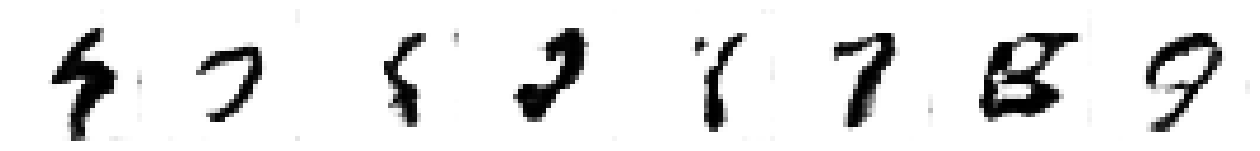

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 27 | disc_loss: 0.8589256405830383 | gen_loss: 1.1930934190750122


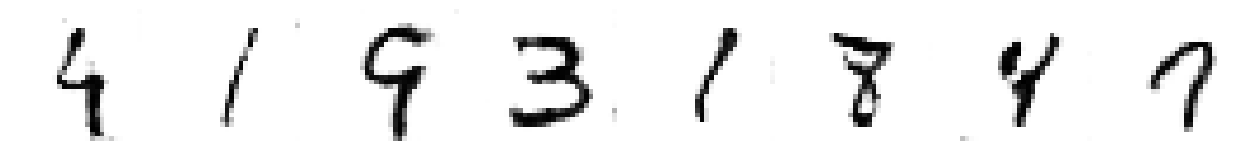

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 28 | disc_loss: 0.9653518199920654 | gen_loss: 0.9337241649627686


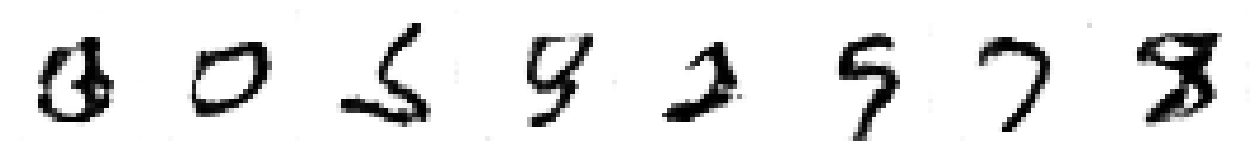

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 29 | disc_loss: 0.8677153587341309 | gen_loss: 1.169478178024292


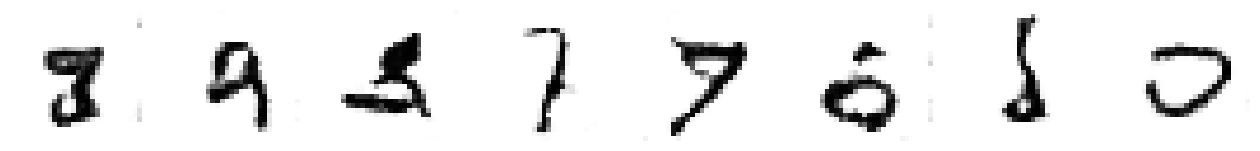

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 30 | disc_loss: 0.8757375478744507 | gen_loss: 1.7708470821380615


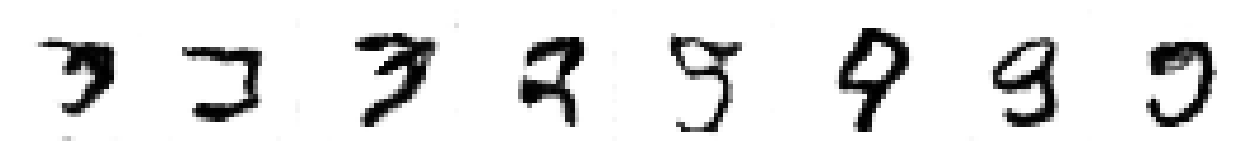

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 31 | disc_loss: 0.9579692482948303 | gen_loss: 0.9116578102111816


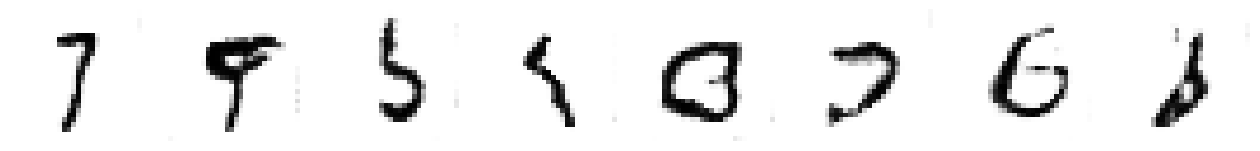

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 32 | disc_loss: 0.868393063545227 | gen_loss: 1.2087981700897217


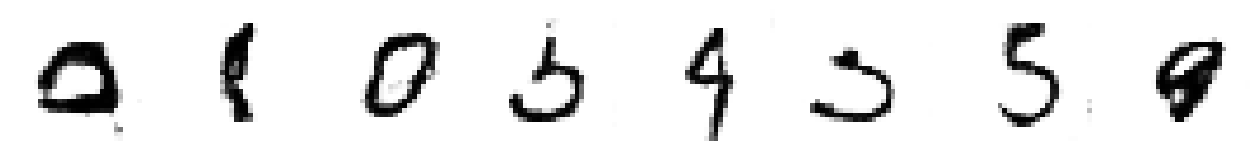

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 33 | disc_loss: 1.009187936782837 | gen_loss: 0.8762930631637573


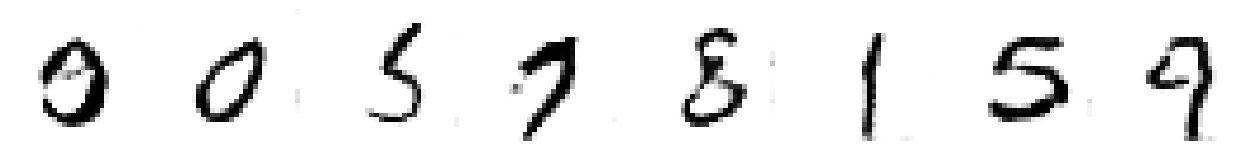

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 34 | disc_loss: 1.0021405220031738 | gen_loss: 0.8774706125259399


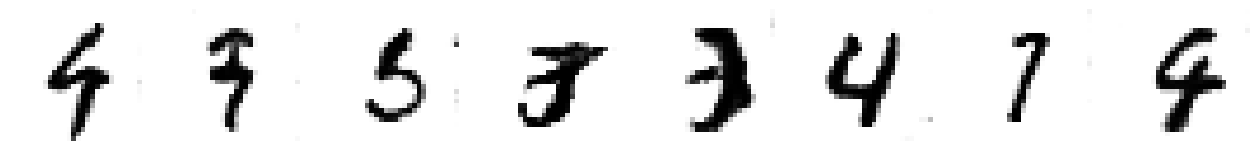

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 35 | disc_loss: 1.026342511177063 | gen_loss: 1.733780860900879


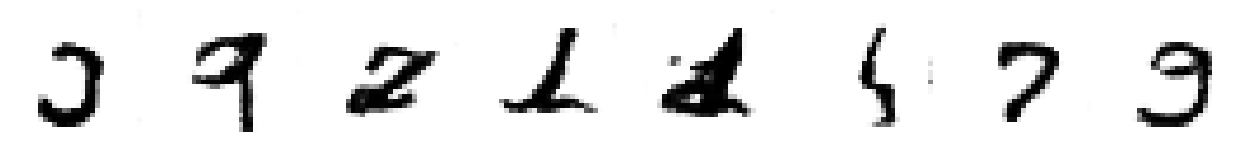

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 36 | disc_loss: 1.0811259746551514 | gen_loss: 1.7547601461410522


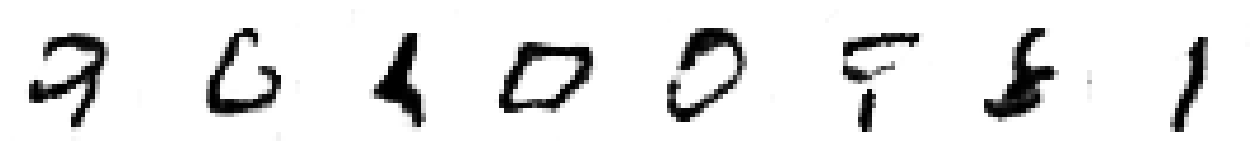

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 37 | disc_loss: 0.9455237984657288 | gen_loss: 1.6479485034942627


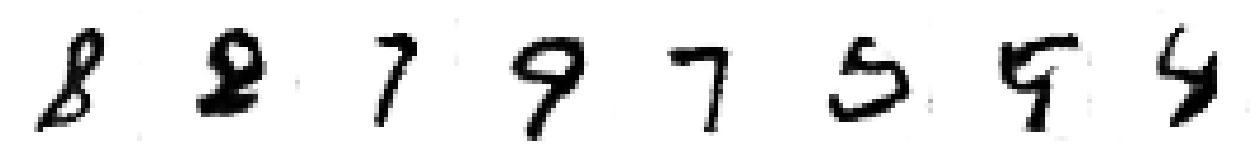

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 38 | disc_loss: 0.8953412771224976 | gen_loss: 1.6496632099151611


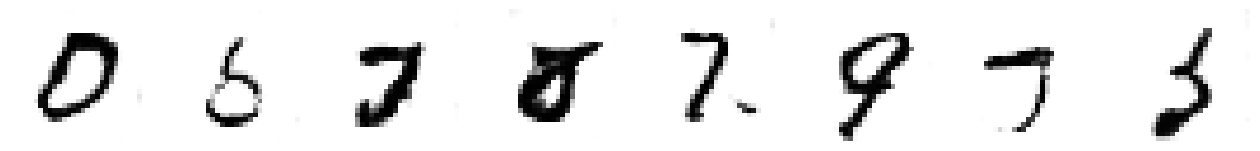

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 39 | disc_loss: 0.9877705574035645 | gen_loss: 1.7165213823318481


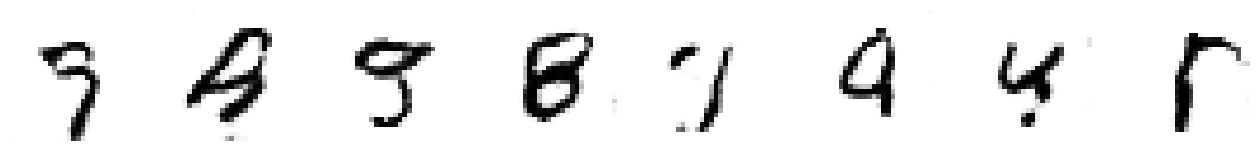

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 40 | disc_loss: 0.9288653135299683 | gen_loss: 1.6556248664855957


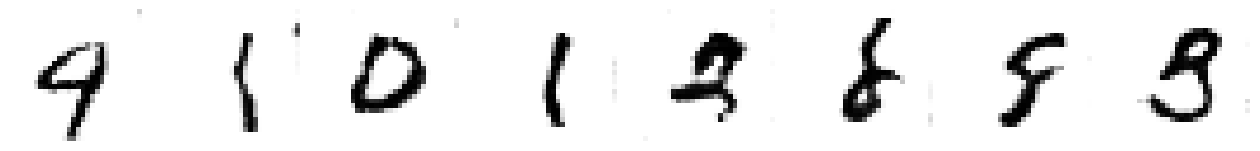

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 41 | disc_loss: 0.9990693926811218 | gen_loss: 1.7813327312469482


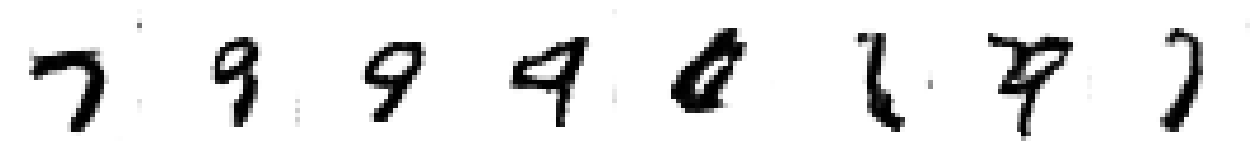

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 42 | disc_loss: 0.9144498705863953 | gen_loss: 1.8047699928283691


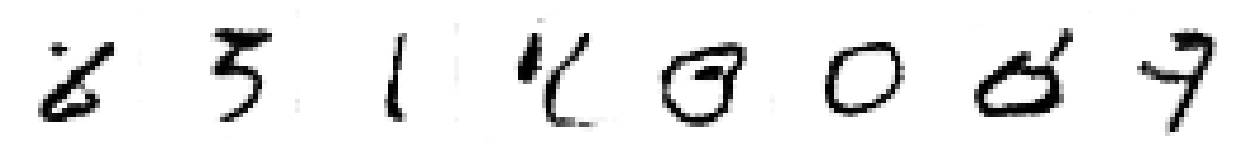

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 43 | disc_loss: 0.8872278332710266 | gen_loss: 1.5575751066207886


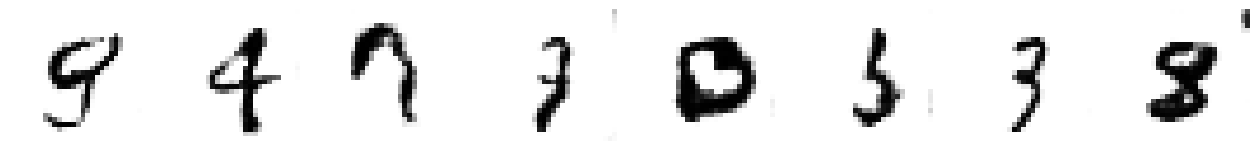

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 44 | disc_loss: 0.9449273943901062 | gen_loss: 1.4533061981201172


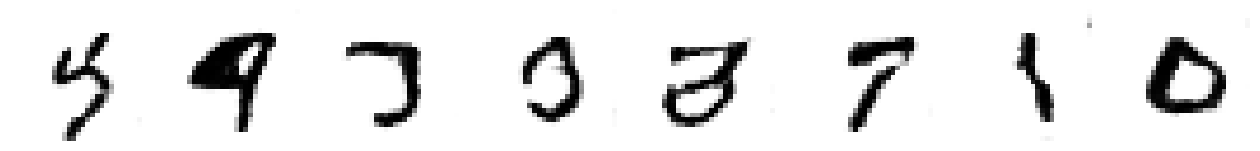

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 45 | disc_loss: 1.0097829103469849 | gen_loss: 1.5332926511764526


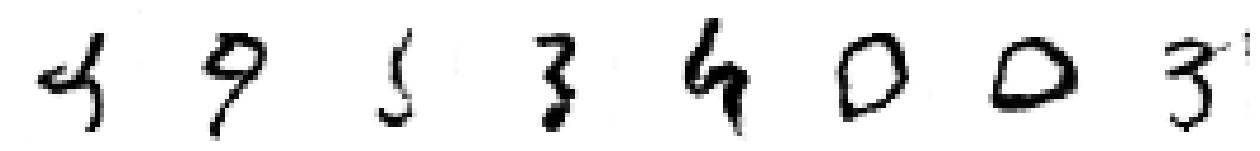

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 46 | disc_loss: 1.0403631925582886 | gen_loss: 0.881640613079071


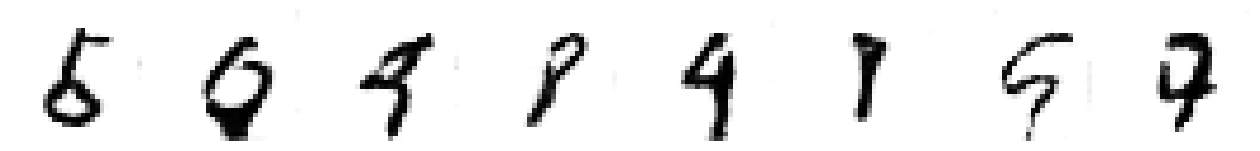

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 47 | disc_loss: 0.9224320650100708 | gen_loss: 1.2874075174331665


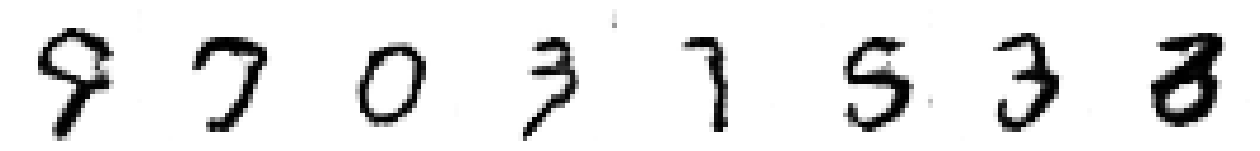

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 48 | disc_loss: 0.9231824278831482 | gen_loss: 1.5798670053482056


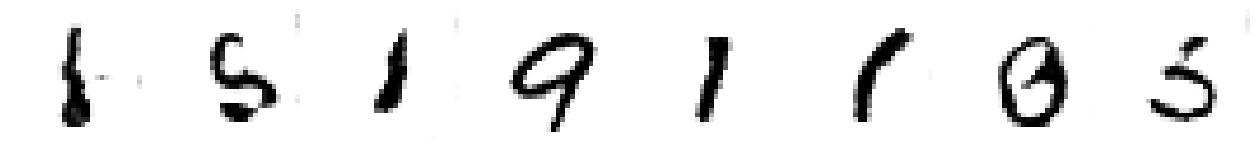

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 49 | disc_loss: 0.9775591492652893 | gen_loss: 1.7486387491226196


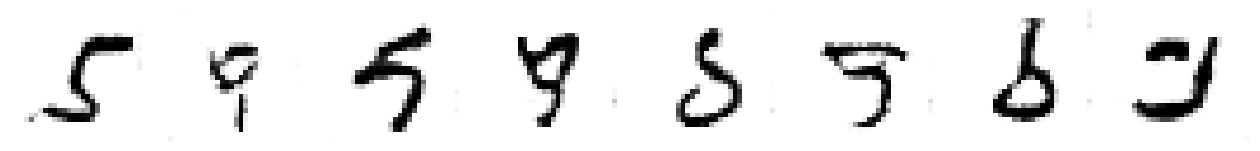

In [100]:
n_epochs = 50
for epoch in range(n_epochs):
    # train
    for batch, train_x in tqdm(
        zip(range(N_TRAIN_BATCHES), train_dataset), total=N_TRAIN_BATCHES
    ):
        model.train(train_x)
    # test on holdout
    loss = []
    for batch, test_x in tqdm(
        zip(range(N_TEST_BATCHES), test_dataset), total=N_TEST_BATCHES
    ):
        loss.append(model.compute_loss(train_x))
    losses.loc[len(losses)] = np.mean(loss, axis=0)
    # plot results
    # display.clear_output()
    print(
        "Epoch: {} | disc_loss: {} | gen_loss: {}".format(
            epoch, losses.disc_loss.values[-1], losses.gen_loss.values[-1]
        )
    )
    plot_reconstruction(model)

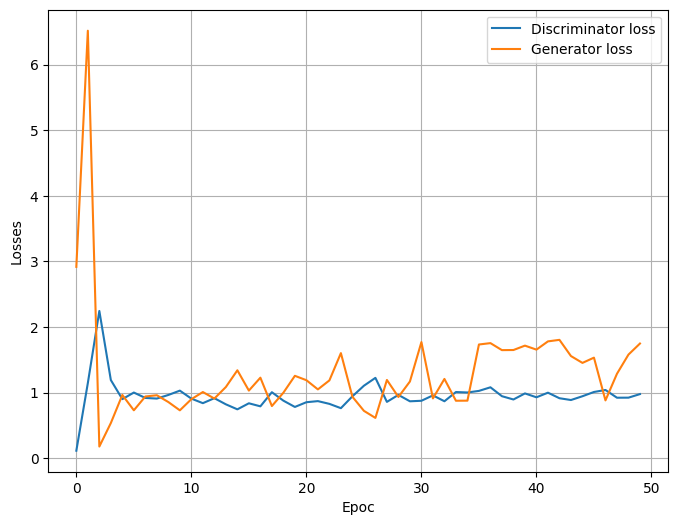

In [101]:
y1 = losses['disc_loss']
y2 = losses['gen_loss']

# Crear el gráfico
plt.figure(figsize=(8, 6))
plt.plot(y1, label='Discriminator loss')
plt.plot(y2, label='Generator loss')
plt.xlabel('Epoc')
plt.ylabel('Losses')
plt.legend()
plt.grid(True)